In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
# import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")




/homes/metogra/iufarias/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic)  + thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

In [ ]:
client = Client(n_workers=90)
# client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42809/status,
Dashboard: http://127.0.0.1:42809/status,Workers: 90
Total threads: 180,Total memory: 503.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42443,Workers: 90
Dashboard: http://127.0.0.1:42809/status,Total threads: 180
Started: Just now,Total memory: 503.40 GiB
Comm: tcp://127.0.0.1:33521,Total threads: 2
Dashboard: http://127.0.0.1:45305/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:44001,


## Reading CROCO (3D)

In [5]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}


path='/data/pacific/lrenault/SASI/CROCO/'

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [7]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [8]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [9]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [11]:
rho_full=df.rho[:,:,120:-120,120:800]
rho_smth=df.rho[:,:,120:-120,120:800]

In [117]:
z_interp=np.linspace(-1,-200, 40)

In [118]:
z=rho_full.z_rho0.compute()

In [119]:
day_x=10

In [120]:
%%time
rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()

CPU times: user 3.42 s, sys: 1.46 s, total: 4.88 s
Wall time: 12 s


In [121]:
%%time
temp_full_interp=temp_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()

CPU times: user 2.82 s, sys: 1.32 s, total: 4.14 s
Wall time: 9.89 s


In [122]:
mld_rho=calc_MLD(rho_full_interp)
mld_kpp=varf.hbl[day_x,120:-120,120:800]

In [ ]:
df.hbl

<xarray.DataArray 'hbl' (ocean_time: 728, eta_rho: 1520, xi_rho: 1000)>
dask.array<concatenate, shape=(728, 1520, 1000), dtype=float32, chunksize=(1, 1520, 1000), chunktype=numpy.ndarray>
Coordinates:
    nav_lat_rho   (eta_rho, xi_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    nav_lon_rho   (eta_rho, xi_rho) float32 dask.array<chunksize=(1520, 1000), meta=np.ndarray>
    time_instant  (ocean_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * ocean_time    (ocean_time) datetime64[ns] 2012-01-01T06:00:00 ... 2012-07-01
  * xi_rho        (xi_rho) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * eta_rho       (eta_rho) int64 0 1 2 3 4 5 ... 1514 1515 1516 1517 1518 1519
Attributes:
    long_name:           depth of planetary boundary layer
    units:               meter
    online_operation:    instant
    interval_operation:  6 h
    interval_write:      6 h
    cell_methods:        time: point
    grid:                <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n...

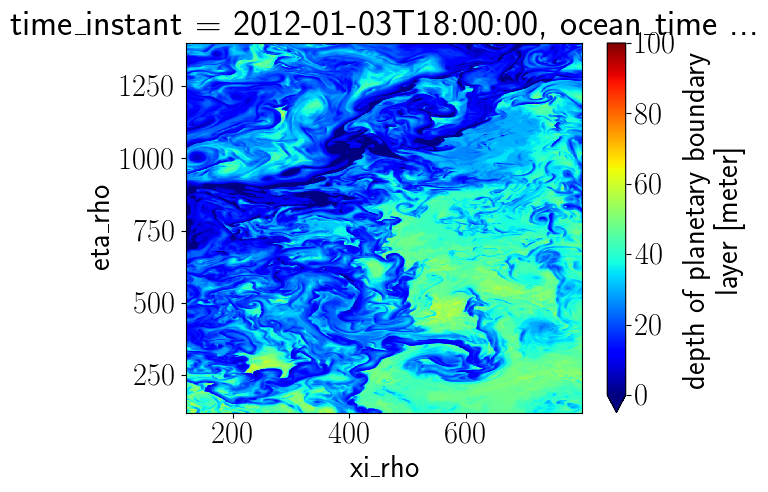

In [146]:
df.hbl[day_x,120:-120,120:800].plot(vmin=0,vmax=100,cmap='jet')

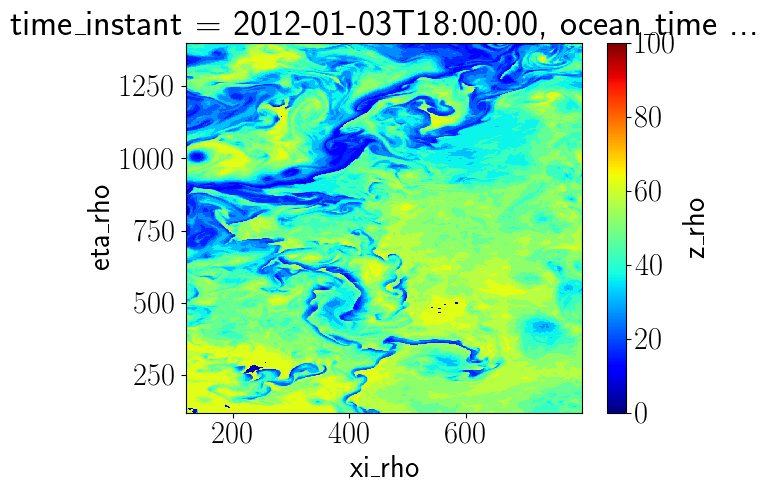

In [128]:
(-calc_MLD(rho_full_interp)).plot(vmin=0,vmax=100,cmap='jet')

Text(0.5, 1.0, '')

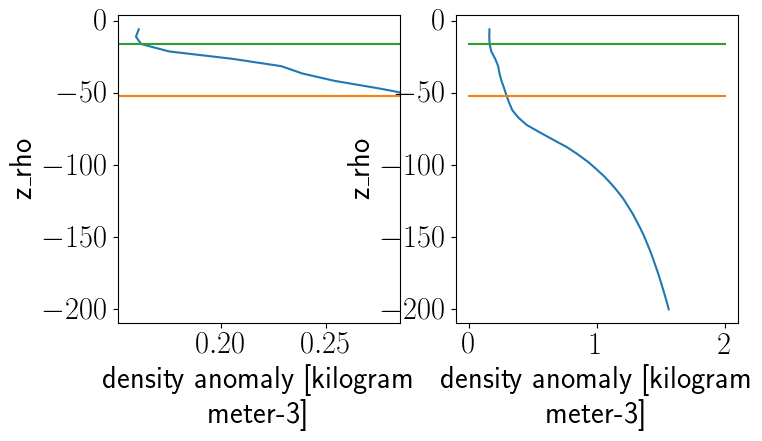

In [131]:
loc_y=250
loc_x=5
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
rho_full_interp[:,loc_y,loc_x].plot(y='z_rho')
plt.plot([0,2],[mld_rho[loc_y,loc_x],mld_rho[loc_y,loc_x]])

plt.plot([0,2],[-mld_kpp[loc_y,loc_x],-mld_kpp[loc_y,loc_x]])
plt.xlim(-0.01+rho_full_interp[1,loc_y,loc_x],rho_full_interp[1,loc_y,loc_x]+0.125)
# plt.xlim(0.15,0.3)


plt.title('')
plt.subplot(1,2,2)
rho_full_interp[:,loc_y,loc_x].plot(y='z_rho')
plt.plot([0,2],[mld_rho[loc_y,loc_x],mld_rho[loc_y,loc_x]])

plt.plot([0,2],[-mld_kpp[loc_y,loc_x],-mld_kpp[loc_y,loc_x]])
# plt.xlim(-0.01+rho_full_interp[0,loc_y,loc_x],rho_full_interp[0,loc_y,loc_x]+0.125)
plt.title('')



In [157]:
df.nav_lat_rho[120:-120,120:800]

<xarray.DataArray 'nav_lat_rho' (eta_rho: 1280, xi_rho: 680)>
dask.array<getitem, shape=(1280, 680), dtype=float32, chunksize=(1280, 680), chunktype=numpy.ndarray>
Coordinates:
    nav_lat_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(1280, 680), meta=np.ndarray>
    nav_lon_rho  (eta_rho, xi_rho) float32 dask.array<chunksize=(1280, 680), meta=np.ndarray>
  * xi_rho       (xi_rho) int64 120 121 122 123 124 125 ... 795 796 797 798 799
  * eta_rho      (eta_rho) int64 120 121 122 123 124 ... 1396 1397 1398 1399
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

In [159]:
MLD_full=xr.DataArray(coords=(df.ocean_time,
                         range(df.rho[:,:,120:-120,120:800].shape[2]),
                         range(df.rho[:,:,120:-120,120:800].shape[3])),
                      dims=['ocean_time','eta_rho','xi_rho'])
MLD_smth=xr.DataArray(coords=(dt.ocean_time,
                         range(df.rho[:,:,120:-120,120:800].shape[2]),
                         range(df.rho[:,:,120:-120,120:800].shape[3])),
                      dims=['ocean_time','eta_rho','xi_rho'])

In [160]:
%%time
for ix in range(df.u.shape[0]):
    rho_full_interp_d=rho_full[ix].xroms.isoslice(z_interp).compute()
    rho_smth_interp_d=rho_smth[ix].xroms.isoslice(z_interp).compute()

    MLD_full[ix,:,:]=(-calc_MLD(rho_full_interp_d)).data
    MLD_smth[ix,:,:]=(-calc_MLD(rho_smth_interp_d)).data

CPU times: user 51min 10s, sys: 26min 56s, total: 1h 18min 7s
Wall time: 2h 41min 7s


In [ ]:
MLD_full.to_netcdf('/homes/metogra/iufarias/Documents/data/MLD/MLD_full_maps.png')
MLD_smth.to_netcdf('/homes/metogra/iufarias/Documents/data/MLD/MLD_smth_maps.png')